<a href="https://colab.research.google.com/github/ShrutiPardeshi24/EVBV-Insurance-Eligibility/blob/main/EVBV_Eligibility_Verification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

import joblib

In [ ]:
df = pd.read_csv('Insurance.csv')
print(df.head())
print(df.info())
print(df.describe())

   age  sex     bmi  children  smoker  region      charges  insuranceclaim
0   19    0  27.900         0       1       3  16884.92400               1
1   18    1  33.770         1       0       2   1725.55230               1
2   28    1  33.000         3       0       2   4449.46200               0
3   33    1  22.705         0       0       1  21984.47061               0
4   32    1  28.880         0       0       1   3866.85520               1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             1338 non-null   int64  
 1   sex             1338 non-null   int64  
 2   bmi             1338 non-null   float64
 3   children        1338 non-null   int64  
 4   smoker          1338 non-null   int64  
 5   region          1338 non-null   int64  
 6   charges         1338 non-null   float64
 7   insuranceclaim  1338 non-null   in

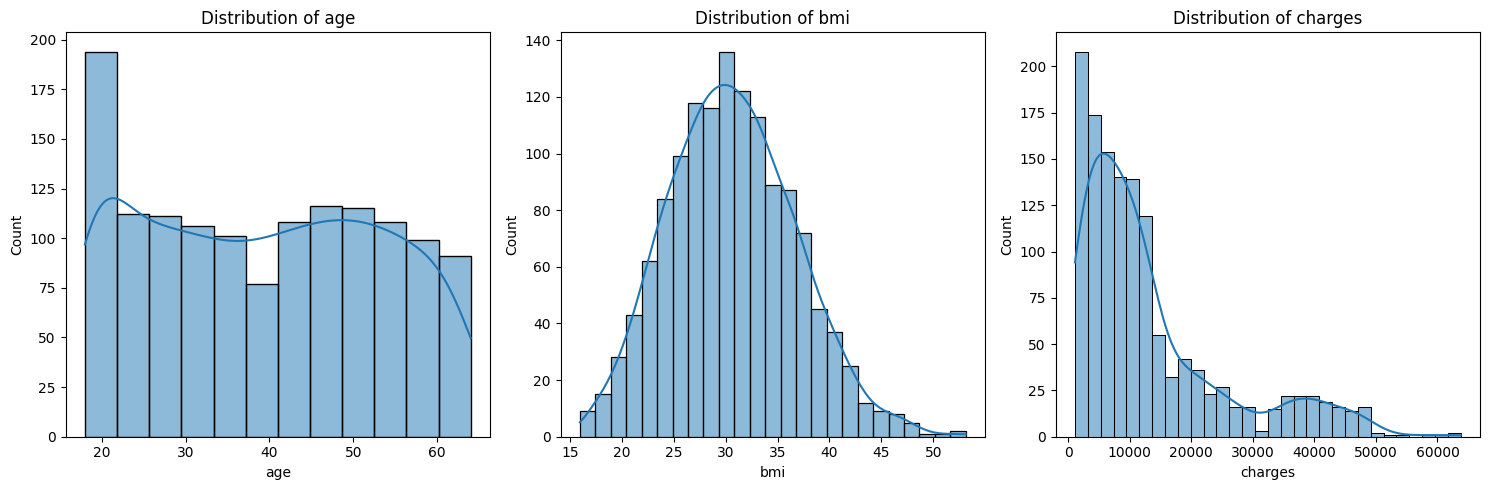

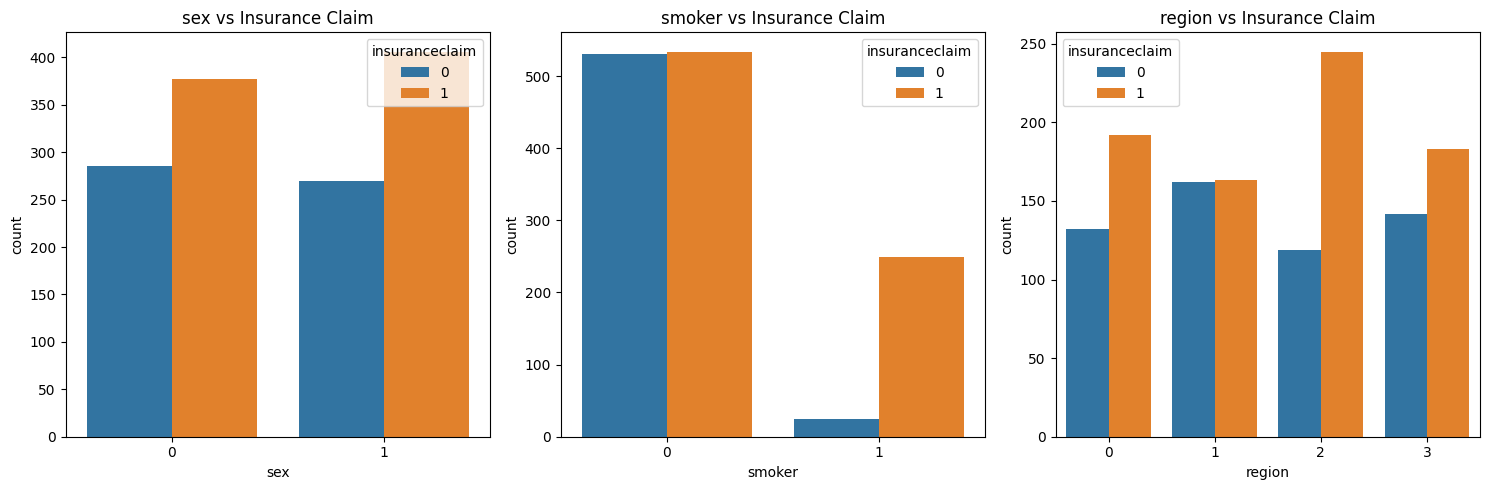

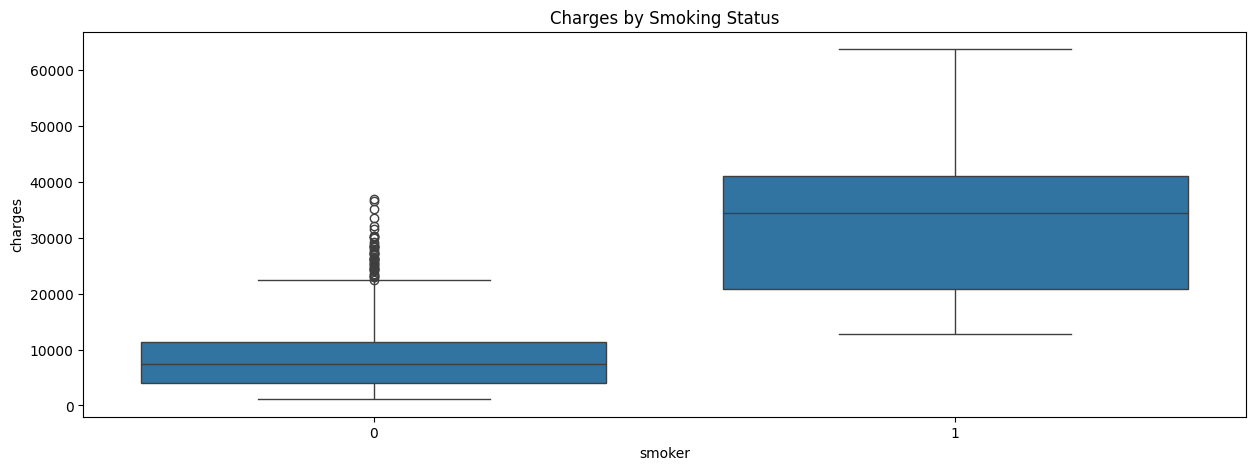

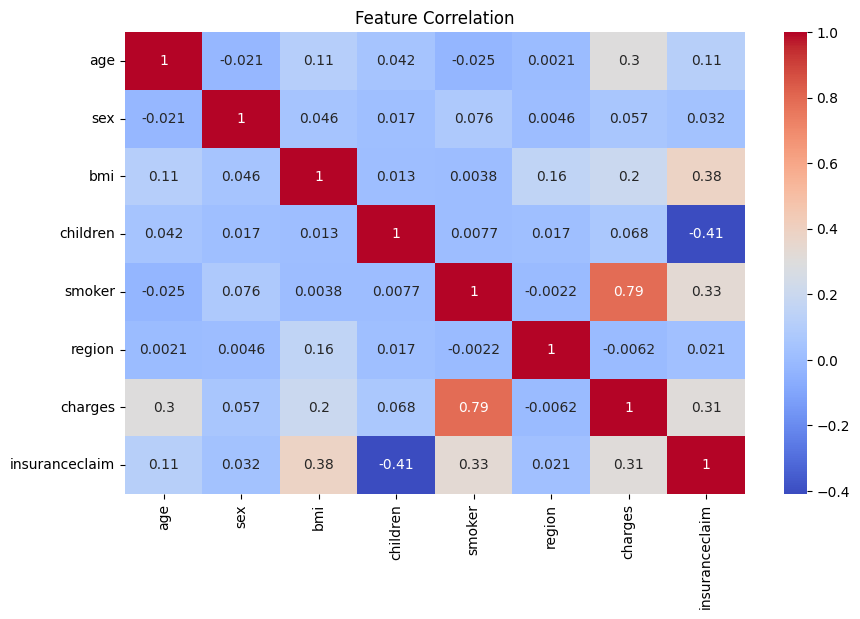

In [ ]:
# Distribution plots
plt.figure(figsize=(15,5))
for i, col in enumerate(['age', 'bmi', 'charges']):
    plt.subplot(1,3,i+1)
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

# Count plots
plt.figure(figsize=(15,5))
for i, col in enumerate(['sex', 'smoker', 'region']):
    plt.subplot(1,3,i+1)
    sns.countplot(x=col, hue='insuranceclaim', data=df)
    plt.title(f'{col} vs Insurance Claim')
plt.tight_layout()
plt.show()

# Box plots
plt.figure(figsize=(15,5))
sns.boxplot(x='smoker', y='charges', data=df)
plt.title('Charges by Smoking Status')
plt.show()

# Correlation heatmap
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation')
plt.show()


In [ ]:
# Preprocessing

df['sex'] = df['sex'].map({0: 'female', 1: 'male'})
df['smoker'] = df['smoker'].map({0: 'no', 1: 'yes'})
df['region'] = df['region'].astype(str)

df_encoded = pd.get_dummies(df, columns=['sex', 'smoker', 'region'], drop_first=True)

X = df_encoded.drop(['insuranceclaim'], axis=1)
y = df_encoded['insuranceclaim']


In [ ]:
# 5. Train-Test Split and Scaling

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:
# 6. Logistic Regression with Tuning

In [ ]:
param_grid = {'C': [0.01, 0.1, 1, 10]}
grid_lr = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid_lr.fit(X_train_scaled, y_train)

y_pred_lr = grid_lr.predict(X_test_scaled)
print("Best Params:", grid_lr.best_params_)
print(classification_report(y_test, y_pred_lr))


Best Params: {'C': 1}
              precision    recall  f1-score   support

           0       0.83      0.79      0.81       107
           1       0.87      0.89      0.88       161

    accuracy                           0.85       268
   macro avg       0.85      0.84      0.84       268
weighted avg       0.85      0.85      0.85       268



In [ ]:
# 7. Random Forest with Tuning

In [ ]:
param_grid = {'n_estimators': [100, 200], 'max_depth': [None, 10, 20]}
grid_rf = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)
grid_rf.fit(X_train, y_train)

y_pred_rf = grid_rf.predict(X_test)
print("Best Params:", grid_rf.best_params_)
print(classification_report(y_test, y_pred_rf))


Best Params: {'max_depth': 20, 'n_estimators': 200}
              precision    recall  f1-score   support

           0       0.91      0.90      0.90       107
           1       0.93      0.94      0.93       161

    accuracy                           0.92       268
   macro avg       0.92      0.92      0.92       268
weighted avg       0.92      0.92      0.92       268



In [ ]:
# 8. XGBoost Classifier

In [ ]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

print(classification_report(y_test, y_pred_xgb))


              precision    recall  f1-score   support

           0       0.95      0.93      0.94       107
           1       0.95      0.97      0.96       161

    accuracy                           0.95       268
   macro avg       0.95      0.95      0.95       268
weighted avg       0.95      0.95      0.95       268



In [ ]:
# 9. ROC Curve Comparison

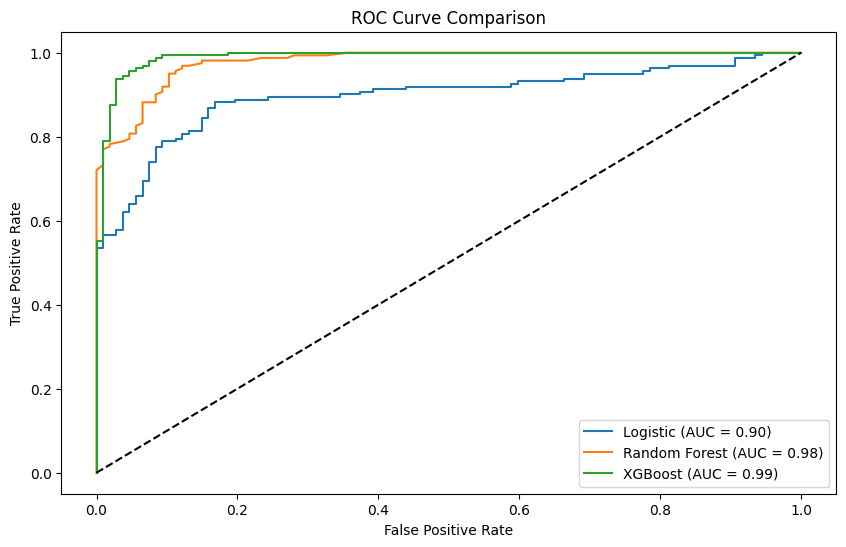

In [ ]:
plt.figure(figsize=(10,6))

for model, name in zip([grid_lr, grid_rf, xgb], ['Logistic', 'Random Forest', 'XGBoost']):
    y_prob = model.predict_proba(X_test_scaled if name=='Logistic' else X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc_score(y_test, y_prob):.2f})')

plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()


In [ ]:
joblib.dump(grid_rf.best_estimator_, 'evbv_rf_model.pkl')


['evbv_rf_model.pkl']

In [ ]:
from sklearn.metrics import accuracy_score

accuracy_lr = accuracy_score(y_test, y_pred_lr)
print("Logistic Regression Accuracy:", accuracy_lr)


Logistic Regression Accuracy: 0.8507462686567164


In [ ]:
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Random Forest Accuracy:", accuracy_rf)


Random Forest Accuracy: 0.9216417910447762


In [ ]:
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print("XGBoost Accuracy:", accuracy_xgb)


XGBoost Accuracy: 0.9514925373134329


In [ ]:
y_pred_dl = model.predict(X_test_scaled)
y_pred_dl_class = (y_pred_dl > 0.5).astype(int)

accuracy_dl = accuracy_score(y_test, y_pred_dl_class)
print("Deep Learning Accuracy:", accuracy_dl)


Deep Learning Accuracy: 0.5559701492537313


In [ ]:
print(f"""
Model Accuracy Comparison:
--------------------------
Logistic Regression : {accuracy_lr:.2f}
Random Forest       : {accuracy_rf:.2f}
XGBoost             : {accuracy_xgb:.2f}
Deep Learning       : {accuracy_dl:.2f}
""")



Model Accuracy Comparison:
--------------------------
Logistic Regression : 0.85
Random Forest       : 0.92
XGBoost             : 0.95
Deep Learning       : 0.56



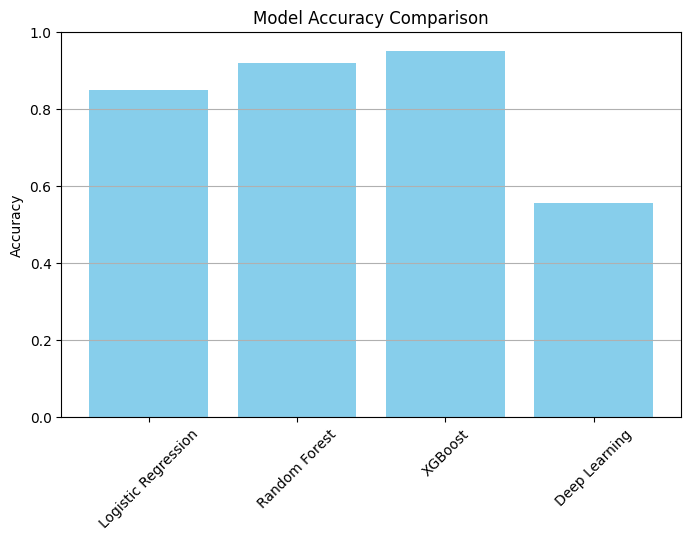

In [ ]:
import matplotlib.pyplot as plt

accuracies = {
    'Logistic Regression': accuracy_lr,
    'Random Forest': accuracy_rf,
    'XGBoost': accuracy_xgb,
    'Deep Learning': accuracy_dl
}

plt.figure(figsize=(8,5))
plt.bar(accuracies.keys(), accuracies.values(), color='skyblue')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


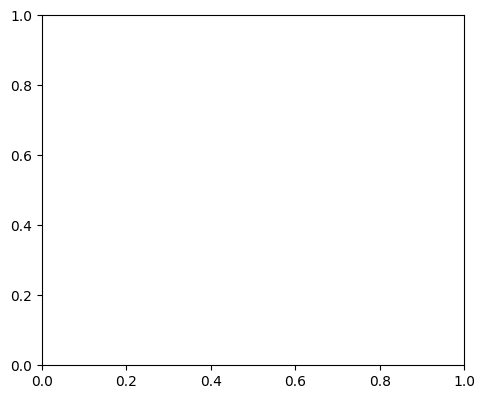

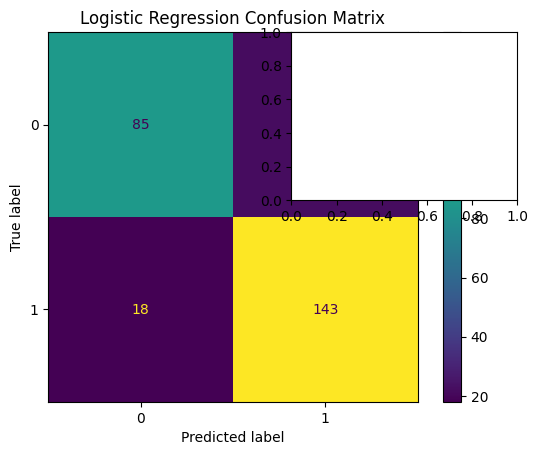

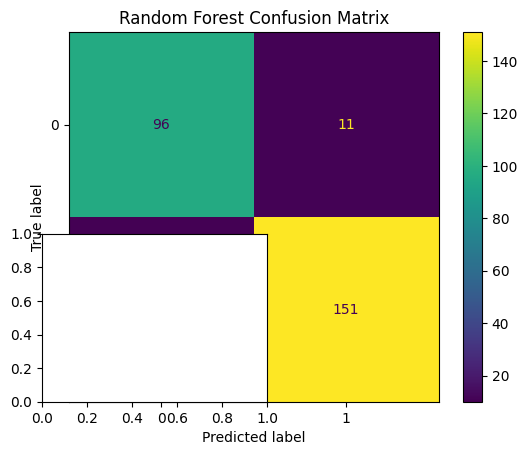

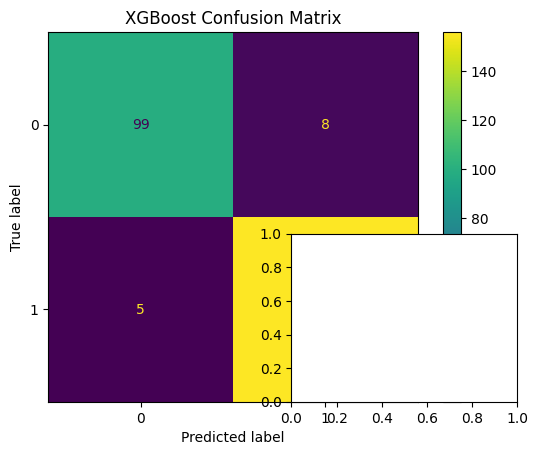

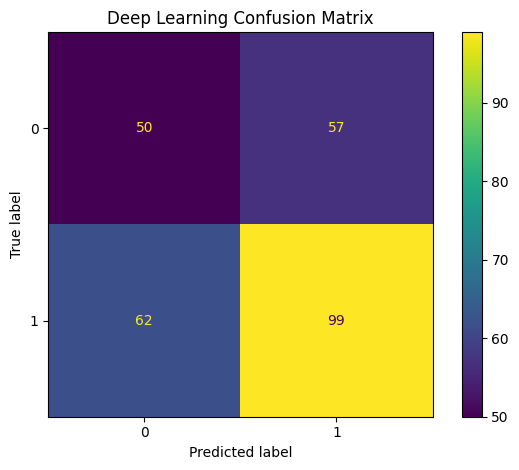

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

models = {
    'Logistic Regression': y_pred_lr,
    'Random Forest': y_pred_rf,
    'XGBoost': y_pred_xgb,
    'Deep Learning': y_pred_dl_class
}

plt.figure(figsize=(12,10))
for i, (name, preds) in enumerate(models.items()):
    plt.subplot(2,2,i+1)
    ConfusionMatrixDisplay.from_predictions(y_test, preds)
    plt.title(f'{name} Confusion Matrix')
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

metrics = {
    'Logistic Regression': {
        'precision': precision_score(y_test, y_pred_lr),
        'recall': recall_score(y_test, y_pred_lr),
        'f1': f1_score(y_test, y_pred_lr)
    },
    'Random Forest': {
        'precision': precision_score(y_test, y_pred_rf),
        'recall': recall_score(y_test, y_pred_rf),
        'f1': f1_score(y_test, y_pred_rf)
    },
    'XGBoost': {
        'precision': precision_score(y_test, y_pred_xgb),
        'recall': recall_score(y_test, y_pred_xgb),
        'f1': f1_score(y_test, y_pred_xgb)
    },
    'Deep Learning': {
        'precision': precision_score(y_test, y_pred_dl_class),
        'recall': recall_score(y_test, y_pred_dl_class),
        'f1': f1_score(y_test, y_pred_dl_class)
    }
}


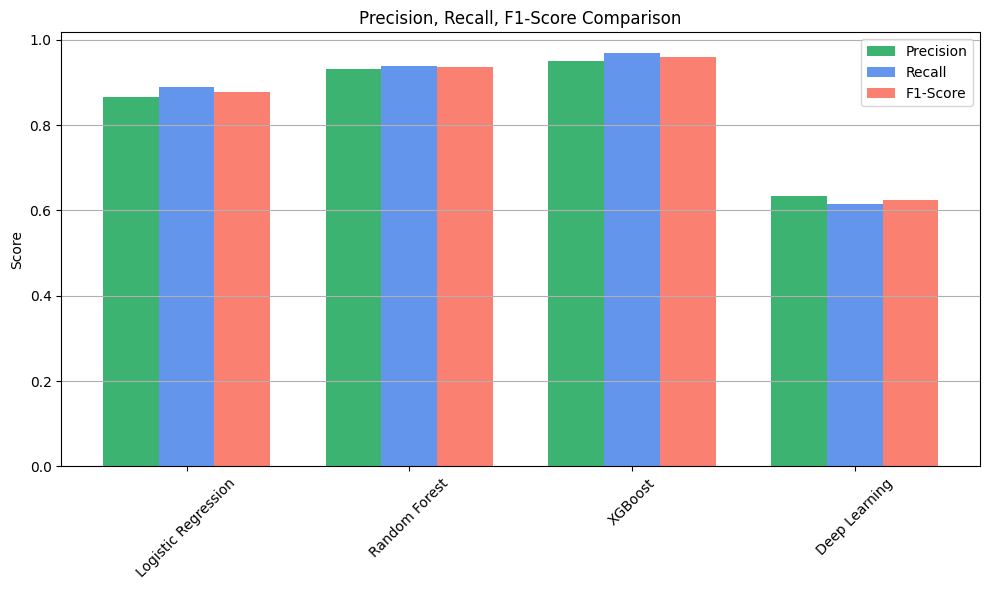

In [ ]:
import matplotlib.pyplot as plt

labels = list(metrics.keys())
precision = [metrics[m]['precision'] for m in labels]
recall = [metrics[m]['recall'] for m in labels]
f1 = [metrics[m]['f1'] for m in labels]

x = np.arange(len(labels))
width = 0.25

plt.figure(figsize=(10,6))
plt.bar(x - width, precision, width, label='Precision', color='mediumseagreen')
plt.bar(x, recall, width, label='Recall', color='cornflowerblue')
plt.bar(x + width, f1, width, label='F1-Score', color='salmon')

plt.xticks(x, labels, rotation=45)
plt.ylabel('Score')
plt.title('Precision, Recall, F1-Score Comparison')
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [ ]:
# Load the saved model for future prediction
model = joblib.load('evbv_rf_model.pkl')

In [ ]:
def predict_insurance_eligibility(age, bmi, children, charges,
                                  sex_male, smoker_yes,
                                  region_northwest, region_southeast, region_southwest):
    # Prepare input data as a pandas DataFrame with the correct feature names
    # The model was trained on 7 features: age, bmi, children, charges, region_1, region_2, region_3
    # sex and smoker were likely one-hot encoded with regions during training.
    # We need to construct the input DataFrame with the same feature order and names.
    input_data = pd.DataFrame([[age, bmi, children, charges,
                               int(region_northwest), int(region_southeast), int(region_southwest)]],
                              columns=['age', 'bmi', 'children', 'charges', 'region_1', 'region_2', 'region_3'])


    # Make prediction
    prediction = model.predict(input_data)[0]

    # Return result
    return "Eligible for Insurance Claim" if prediction == 1 else "Not Eligible"

In [ ]:
print("Testing with different inputs:")

# Test Case 1: A young, non-smoking individual with no children and low charges
result1 = predict_insurance_eligibility(
    age=25,
    bmi=22.0,
    children=0,
    charges=3000,
    sex_male=False,
    smoker_yes=False,
    region_northwest=True,
    region_southeast=False,
    region_southwest=False
)
print(f"Test Case 1 Prediction: {result1}")

# Test Case 2: An older, smoking individual with multiple children and high charges
result2 = predict_insurance_eligibility(
    age=60,
    bmi=35.0,
    children=3,
    charges=45000,
    sex_male=True,
    smoker_yes=True,
    region_northwest=False,
    region_southeast=True,
    region_southwest=False
)
print(f"Test Case 2 Prediction: {result2}")

# Test Case 3: A middle-aged individual with average characteristics
result3 = predict_insurance_eligibility(
    age=40,
    bmi=28.0,
    children=1,
    charges=8000,
    sex_male=False,
    smoker_yes=False,
    region_northwest=False,
    region_southeast=False,
    region_southwest=True
)
print(f"Test Case 3 Prediction: {result3}")

Testing with different inputs:
Test Case 1 Prediction: Not Eligible
Test Case 2 Prediction: Eligible for Insurance Claim
Test Case 3 Prediction: Not Eligible


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
